In [31]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%load_ext blackcellmagic

In [3]:
%autoreload 2

In [4]:
from prefect import Flow, Parameter, unmapped
import pandas as pd
from prefect.engine.executors import DaskExecutor

In [5]:
input_df = pd.read_csv("../data/house-prices-advanced-regression-techniques/train.csv")
test= pd.read_csv("../data/house-prices-advanced-regression-techniques/test.csv")

In [34]:
from ml_flow import *

with Flow("data_cleaning") as flow:
    input_data = Parameter("input_data")
    problem, target, features = (
        Parameter("problem"),
        Parameter("target"),
        Parameter("features"),
    )
    
    
    
    
    nan_features = extract_nan_features(input_data)
    problematic_features = extract_problematic_features(input_data)
    undefined_features = extract_undefined_features(
        input_data, features, target, nan_features, problematic_features
    )
    input_data_with_missing = fit_transform_missing_indicator(input_data, undefined_features)

    train_valid_split = extract_train_valid_split(
        input_data=input_data_with_missing, problem=problem, target=target
    )
    train_data = extract_train_data(train_valid_split)
    valid_data = extract_valid_data(train_valid_split)
    numeric_features = extract_numeric_features(input_data, undefined_features)
    categorical_features = extract_categorical_features(input_data, undefined_features)
    
    

    # numeric columns work
    numeric_imputer = fit_numeric_imputer(train_data, numeric_features)
    imputed_train_numeric_df = impute_numeric_df(
        numeric_imputer, train_data, numeric_features
    )
    imputed_valid_numeric_df = impute_numeric_df(
        numeric_imputer, valid_data, numeric_features
    )

    yeo_johnson_transformer = fit_yeo_johnson_transformer(imputed_train_numeric_df)
    yeo_johnson_train_transformed = transform_yeo_johnson_transformer(
        imputed_train_numeric_df, yeo_johnson_transformer
    )
    yeo_johnson_valid_transformed = transform_yeo_johnson_transformer(
        imputed_valid_numeric_df, yeo_johnson_transformer
    )

    # categorical columns work
    categorical_imputer = fit_categorical_imputer(train_data, categorical_features)
    imputed_train_categorical_df = transform_categorical_data(
        train_data, categorical_features, categorical_imputer
    )
    imputed_valid_categorical_df = transform_categorical_data(
        valid_data, categorical_features, categorical_imputer
    )

    target_transformer = fit_target_transformer(problem, target, train_data)
    transformed_train_target = transform_target(
        problem, target, train_data, target_transformer
    )
    transformed_valid_target = transform_target(
        problem, target, valid_data, target_transformer
    )

    target_encoder_transformer = fit_target_encoder(
        imputed_train_categorical_df, transformed_train_target
    )
    target_encoded_train_df = target_encoder_transform(
        target_encoder_transformer, imputed_train_categorical_df
    )
    target_encoded_valid_df = target_encoder_transform(
        target_encoder_transformer, imputed_valid_categorical_df
    )

    # merge_data
    transformed_train_df = merge_transformed_data(
        target_encoded_train_df,
        yeo_johnson_train_transformed,
    )
    transformed_valid_df = merge_transformed_data(
        target_encoded_valid_df,
        yeo_johnson_valid_transformed,
    )

    # outlierness
    hbos_transformer = fit_hbos_transformer(transformed_train_df)
    hbos_transform_train_data = hbos_transform(transformed_train_df, hbos_transformer)
    hbos_transform_valid_data = hbos_transform(transformed_valid_df, hbos_transformer)

    # merge outlierness
    transformed_train_df = merge_hbos_df(
        transformed_train_df, hbos_transform_train_data
    )
    transformed_valid_df = merge_hbos_df(
        transformed_valid_df, hbos_transform_valid_data
    )
    
    # models
    models = generate_models(problem)
    #debug(transformed_train_df,transformed_valid_df)
    fit_models = fit_model.map(
        model=models,
        train_data=unmapped(transformed_train_df),
        target=unmapped(transformed_train_target),
        problem=unmapped(problem),
    )
    predict_models = predict_model.map(
    model = fit_models,
    valid_data = unmapped(transformed_valid_df),
    )

In [35]:
executor = DaskExecutor()
flow_state = flow.run(
    input_data= input_df, 
    problem="regression", 
    target = "SalePrice", 
    features = "infer",
    executor=executor
)

[2020-03-01 23:02:16,104] INFO - prefect.FlowRunner | Beginning Flow run for 'data_cleaning'
[2020-03-01 23:02:16,120] INFO - prefect.FlowRunner | Starting flow run.
[2020-03-01 23:02:17,292] INFO - prefect.TaskRunner | Task 'target': Starting task run...
[2020-03-01 23:02:17,456] INFO - prefect.TaskRunner | Task 'target': finished task run for task with final state: 'Success'
[2020-03-01 23:02:17,563] INFO - prefect.TaskRunner | Task 'features': Starting task run...
[2020-03-01 23:02:17,778] INFO - prefect.TaskRunner | Task 'features': finished task run for task with final state: 'Success'
[2020-03-01 23:02:17,766] INFO - prefect.TaskRunner | Task 'input_data': Starting task run...
[2020-03-01 23:02:18,434] INFO - prefect.TaskRunner | Task 'input_data': finished task run for task with final state: 'Success'
[2020-03-01 23:02:18,534] INFO - prefect.TaskRunner | Task 'problem': Starting task run...
[2020-03-01 23:02:19,226] INFO - prefect.TaskRunner | Task 'problem': finished task run f

/mnt/c/Users/cwcol/projects/crawto/venv/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[2020-03-01 23:02:34,094] INFO - prefect.TaskRunner | Task 'fit_yeo_johnson_transformer': finished task run for task with final state: 'Success'
[2020-03-01 23:02:34,489] INFO - prefect.TaskRunner | Task 'extract_valid_data': Starting task run...
[2020-03-01 23:02:35,517] INFO - prefect.TaskRunner | Task 'extract_valid_data': finished task run for task with final state: 'Success'
[2020-03-01 23:02:35,132] INFO - prefect.TaskRunner | Task 'fit_target_encoder': Starting task run...
[2020-03-01 23:02:35,851] INFO - prefect.TaskRunner | Task 'transform_yeo_johnson_transformer': Starting task run...
[2020-03-01 23:02:37,879] INFO - prefect.TaskRunner | Task 'transform_yeo_johnson_transformer': finished task run for task with final state: 'Success'
[2020-03-01 23:02:42,270] INFO - prefect.TaskRunner | Task 'transform_target': Starting task run...
[2020-03-01 23:02:43,851] INFO - prefect.TaskRunner | Task 'fit_target_encoder': finished task run for task with final state: 'Success'
[2020-03-01

/mnt/c/Users/cwcol/projects/crawto/venv/lib/python3.6/site-packages/distributed/worker.py:3339: UserWarning: Large object of size 1.27 MB detected in task graph: 
  (None, 0, {<Edge (key=target): transform_target to ...  succeeded.">})
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


[2020-03-01 23:03:57,431] INFO - prefect.TaskRunner | Task 'fit_model[0]': Starting task run...
[2020-03-01 23:03:57,607] INFO - prefect.TaskRunner | Task 'fit_model[1]': Starting task run...
[2020-03-01 23:03:59,534] INFO - prefect.TaskRunner | Task 'fit_model[0]': finished task run for task with final state: 'Success'
[2020-03-01 23:03:59,654] INFO - prefect.TaskRunner | Task 'fit_model[1]': finished task run for task with final state: 'Success'
[2020-03-01 23:03:59,845] INFO - prefect.TaskRunner | Task 'fit_model[2]': Starting task run...
[2020-03-01 23:03:59,909] WARNING - prefect.Task: fit_model | Warning: Inappropriate model for regression.
[2020-03-01 23:03:59,929] INFO - prefect.TaskRunner | Task 'fit_model[2]': finished task run for task with final state: 'Success'
[2020-03-01 23:03:59,891] INFO - prefect.TaskRunner | Task 'fit_model[3]': Starting task run...
[2020-03-01 23:04:00,077] INFO - prefect.TaskRunner | Task 'fit_model[4]': Starting task run...
[2020-03-01 23:04:00,44

/mnt/c/users/cwcol/projects/crawto/crawto/ml_flow.py:254: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(X=train_data,y= target)


[2020-03-01 23:04:00,581] INFO - prefect.TaskRunner | Task 'fit_model[4]': finished task run for task with final state: 'Success'
[2020-03-01 23:04:01,311] INFO - prefect.TaskRunner | Task 'fit_model[5]': Starting task run...
[2020-03-01 23:04:01,949] INFO - prefect.TaskRunner | Task 'fit_model[5]': finished task run for task with final state: 'Success'
[2020-03-01 23:04:02,101] INFO - prefect.TaskRunner | Task 'fit_model[6]': Starting task run...
[2020-03-01 23:04:02,394] INFO - prefect.TaskRunner | Task 'fit_model[6]': finished task run for task with final state: 'Success'
[2020-03-01 23:04:03,442] INFO - prefect.TaskRunner | Task 'fit_model[3]': finished task run for task with final state: 'Success'
[2020-03-01 23:04:03,590] INFO - prefect.TaskRunner | Task 'fit_model': finished task run for task with final state: 'Mapped'
[2020-03-01 23:04:03,715] INFO - prefect.TaskRunner | Task 'predict_model': Starting task run...
[2020-03-01 23:04:07,561] INFO - prefect.TaskRunner | Task 'predi

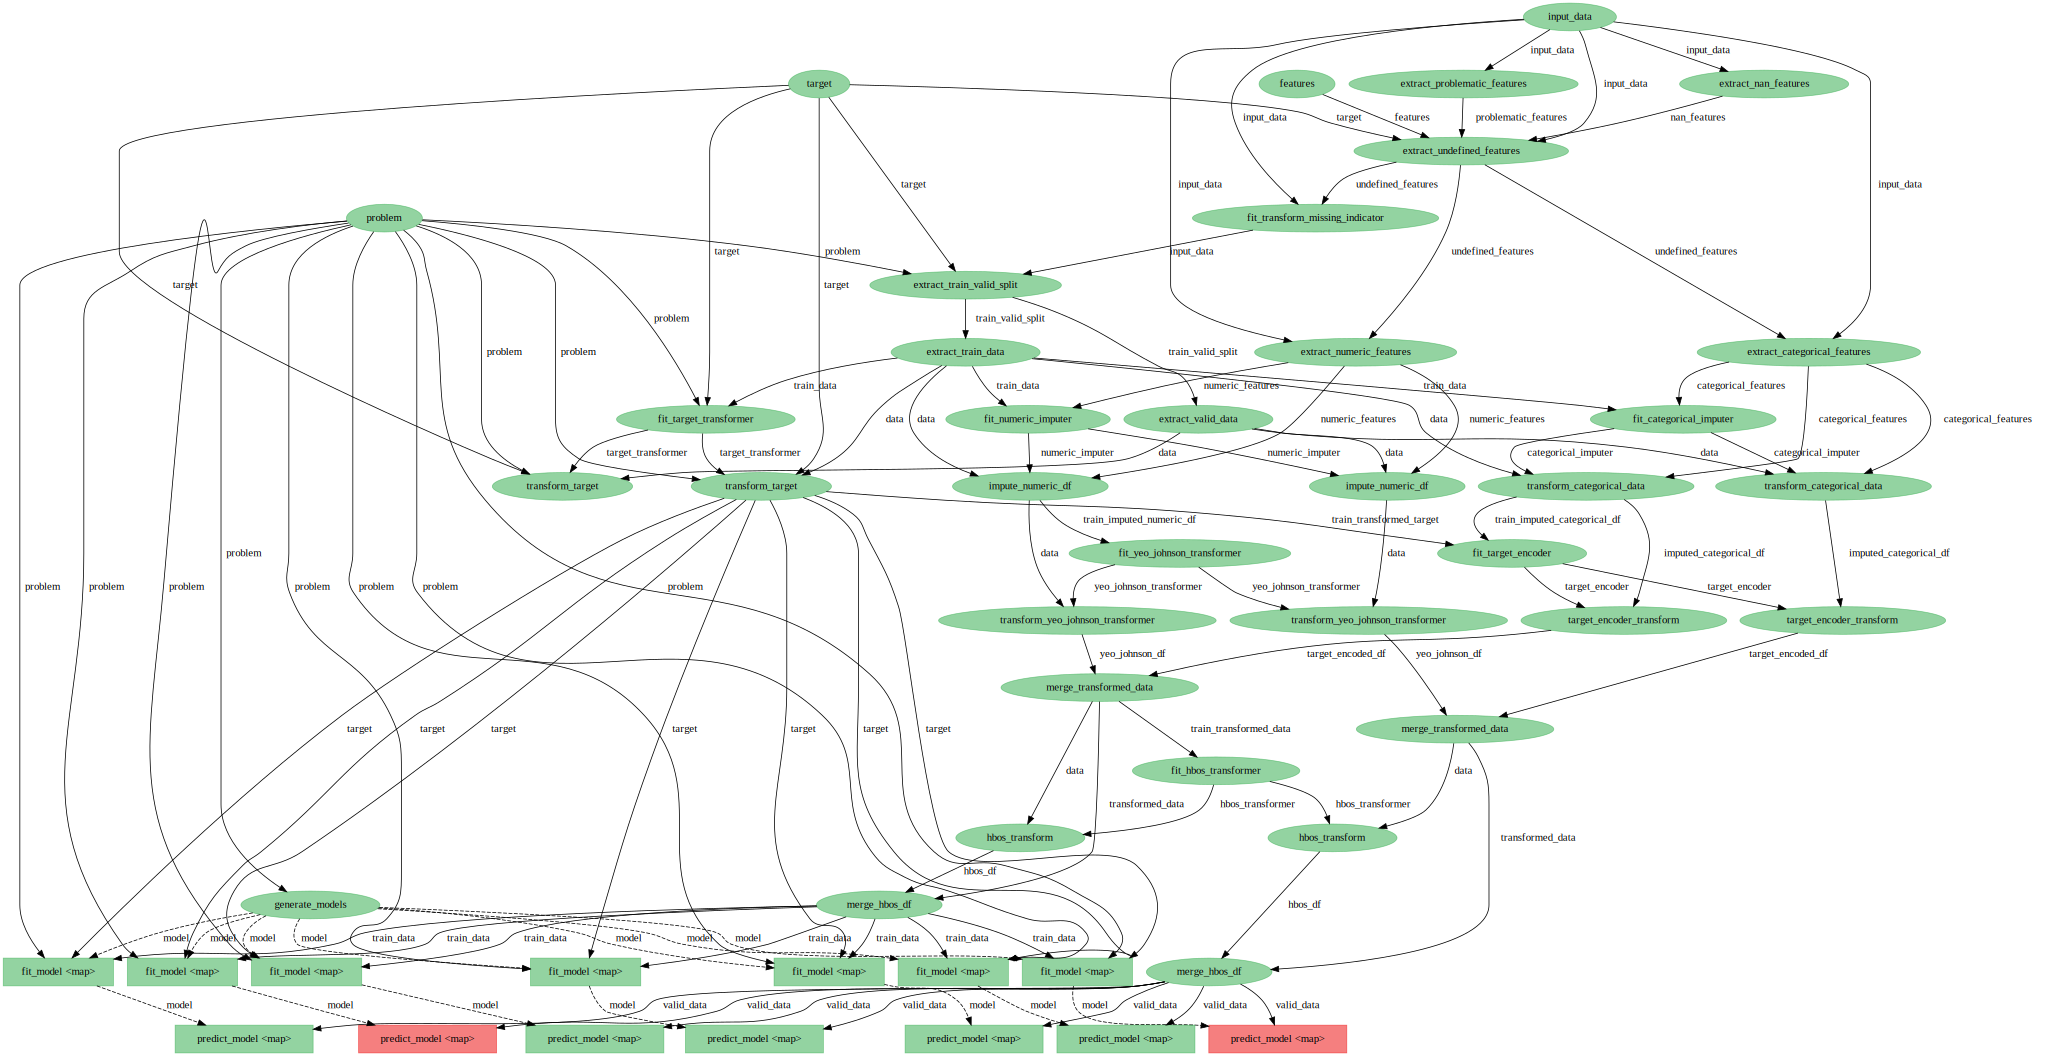

In [36]:
flow.visualize(flow_state=flow_state)